### Juan David Orjuela - Sofía Álvarez López

In [49]:
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#from keras import regularizers
from sklearn import preprocessing 
from scipy.stats import percentileofscore
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense #, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

<h1 align='center'>Laboratorio 4: Machine Learning Techniques</h1>

## Problema 2

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

Fuente de Datos: https://www.kaggle.com/mlg-ulb/creditcardfraud


### Exploración de los datos

Kaggle nos informa que los datos corresponden a transacciones de tarjeta de crédito hechas durante dos días en Septiembre de 2013 por tarjetahabientes europeos. Es un conjunto altamente desbalanceado, con sólo el 0.172% correspondiente a transacciones fraudulentas. Por motivos de confidencialidad, los datos se han tranformado mediante un PCA (28 componentes), exceptuando "Time" y "Amount", que corresponden al tiempo en segundos entre cada transacción y la primera transacción del set de datos, y al monto de la transacción respectivamente. La variable "Class" es la variable de clasificación, y corresponde a 1 en caso de fraude o a 0 en caso contrario.

Leamos nuestros datos y miremos una muestra aleatoria de 5 transacciones:

In [2]:

df=pd.read_csv("creditcard.csv")
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
73081,54967.0,1.324194,-0.602670,-1.506269,-2.500824,1.685720,2.825259,-0.617556,0.695141,1.118843,...,0.118530,0.282549,-0.234656,1.085511,0.829952,0.231561,-0.005553,0.008500,34.95,0
102211,68090.0,1.281097,-1.384941,0.292698,-1.215141,-1.729558,-1.000470,-0.787902,-0.247658,-1.764819,...,-0.147098,-0.339822,-0.067101,0.346017,0.321317,-0.216936,0.002607,0.041034,136.90,0
115010,73714.0,-0.546412,0.875540,0.713896,0.194675,-0.489044,-0.706589,0.698714,0.353790,-0.686769,...,-0.261125,-1.101794,0.569623,0.323488,-0.768616,-0.225045,-0.129830,-0.016797,93.72,0
82938,59617.0,1.247712,-0.683654,0.712327,0.782667,-0.949646,0.575000,-0.903884,0.275532,0.091740,...,-0.493165,-0.670173,-0.038954,-0.489415,0.513214,-0.220537,0.086620,0.020286,16.75,0
150127,92604.0,-1.388467,0.862321,0.989902,-0.357932,-0.451701,-0.341738,0.030970,0.297660,1.750565,...,0.112602,0.822449,-0.260704,-0.068535,-0.260742,0.558898,0.258846,0.192128,69.99,0


Ahora, revisamos si hay algún dato nulo en nuestro conjunto de datos. Notamos que el "máximo" de nulos es 0: es decir, ¡no hay nulos en el conjuntos de datos!

In [4]:
print('Cantidad de nulos:', df.isnull().sum().max())

Cantidad de nulos: 0


Asimismo, revisamos que, en efecto, las clases que hay corresponden a 0 (transacción corriente) y 1 (fraude).

In [6]:
print(f"Las clases presentes en el data set son: {np.unique(df['Class'])}" )

Las clases presentes en el data set son: [0 1]


Ahora, veamos qué tan desbalanceadas están las clases. Esperamos que haya gran desbalance, pues las transacciones fraudulentas son pocas, pero pueden representan pérdidas de millones de dólares anuales.

In [9]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


O, gráficamente, tenemos que:

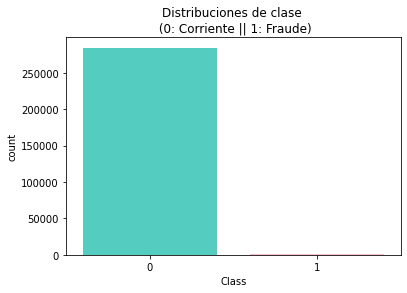

In [16]:
sns.countplot('Class', data=df, palette=['turquoise', 'lightpink'])
plt.title('Distribuciones de clase \n (0: Corriente || 1: Fraude)')
plt.show()

Son tan poquitas transacciones fraudulentas (únicamente el 0.17%) que prácticamente es despreciable en la gráfica de arriba.

Ahora, veamos una descripción estadística de las variables del PCA que se nos ha dado:

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Notamos que la media de casi todos los componentes es cercana a 0, pues todos son del orden de $10^{-15}$ y $10^{-16}$. Asimismo, podemos apreciar que la transacción promedio tarda 94.813 ms y el monto promedio por transacción es 88.3 euros. No hay mucha más información que podamos rescatar de esto, pues las 28 variables son las componentes principales del PCA realizado.  

Ahora, veamos si tenemos datos duplicados:

In [23]:
df.duplicated().sum()

1081

Porcentualmente, esto es:

In [32]:
print(np.round(100*df.duplicated().sum()/df.shape[0], 2))

0.38


Y, para la clase positiva,

In [33]:
print(np.round(100*((df["Class"]*df.duplicated()).sum())/df["Class"].sum(), 2))

3.86


Podemos ver que solo el 0.38% de los datos están duplicados, y que 3.86% de los duplicados corresponden a la clase positiva. En realidad, es un porcentaje muy bajo. Debido a que no tenemos el conjunto de datos original, no sabemos si es un error espurio de la toma de datos o si, en efecto, así fueron las transacciones. Por lo tanto, no consideramos pertinente quitar estos datos.

Ahora, veamos las distribuciones (en histogramas) de cada una de las variables que estamos estudiando. 

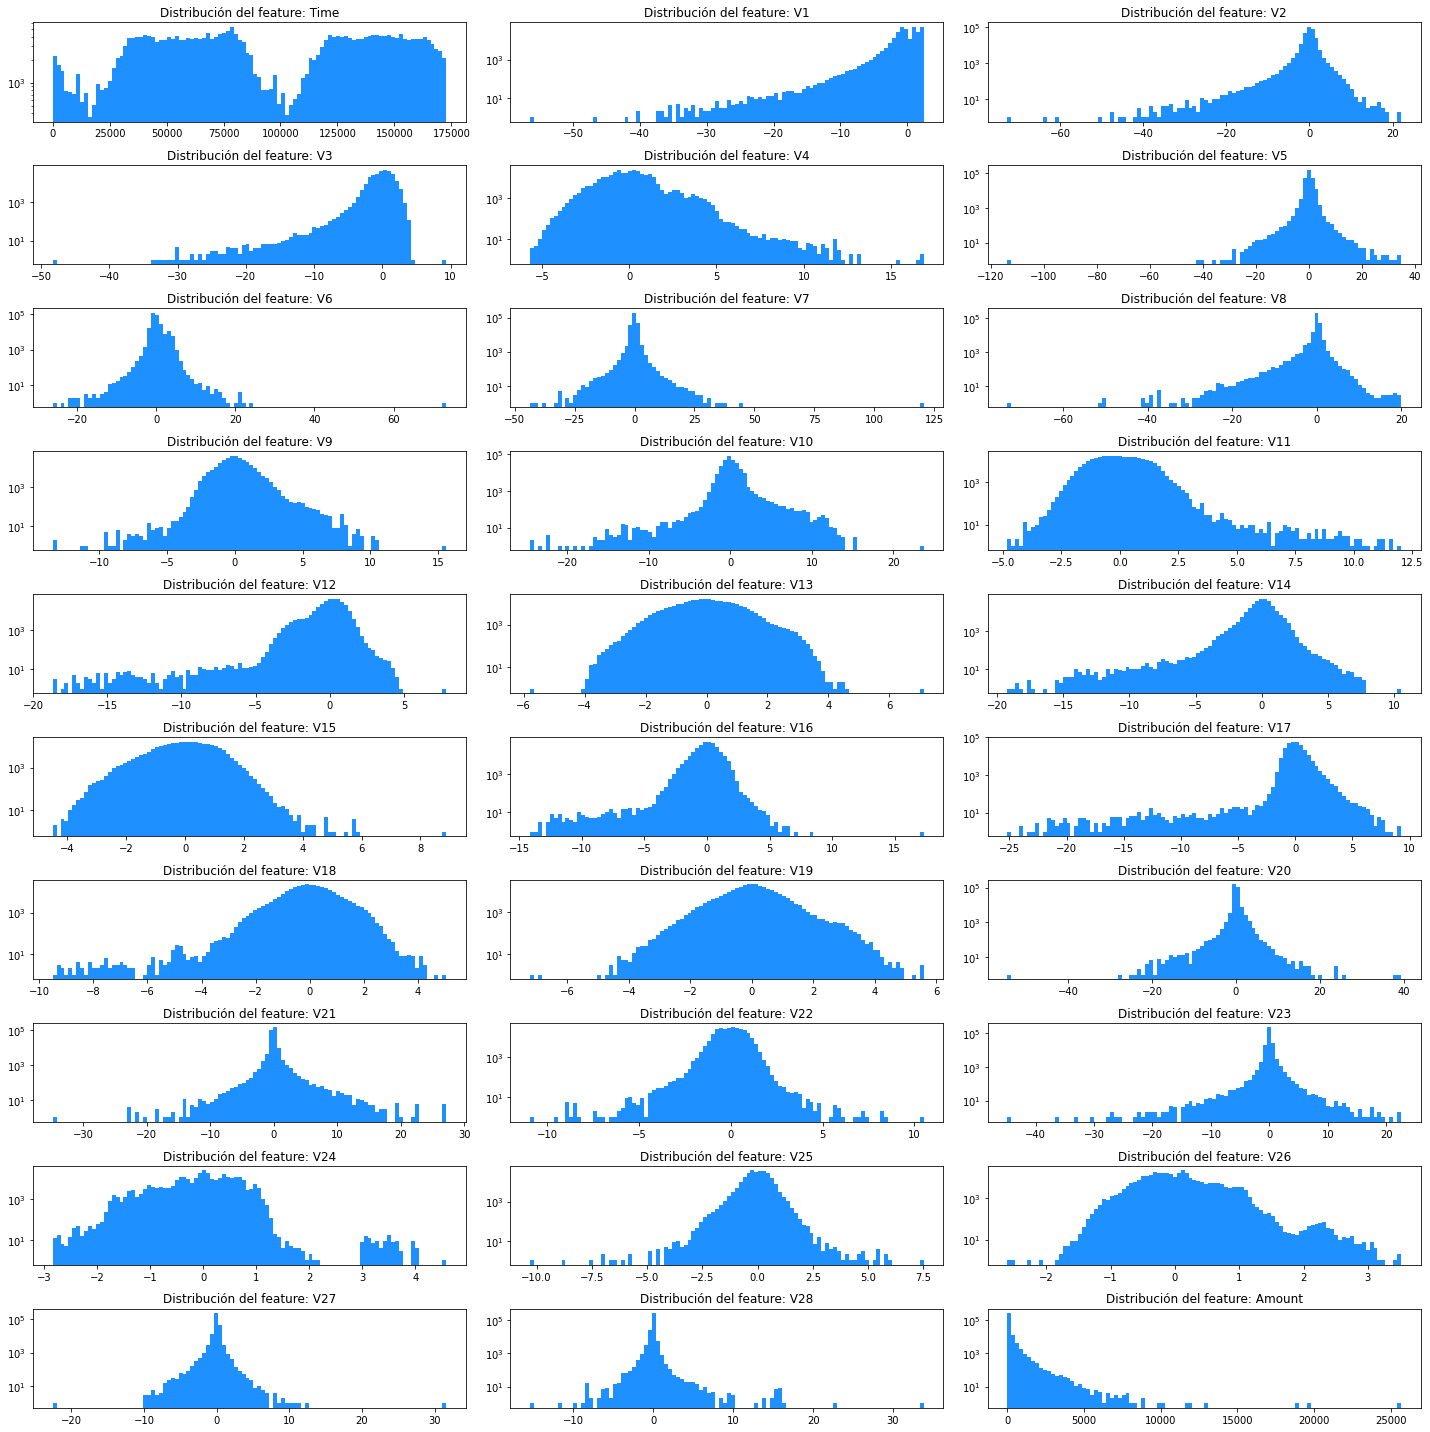

In [34]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=100,ax=ax,facecolor='dodgerblue')
        ax.set_title('Distribución del feature: ' + feature)
        ax.set_yscale('log')
        ax.grid(False)
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.drop('Class', axis=1).columns,10,3)

Se graficó en escala logarítmica en y para lograr observar los valores pequeños. Para la variable del tiempo se obtiene una distribución correspondiente a una serie de tiempo de periodo de un día. Es altamente probable que los valles correspondan a las horas de la madrugada, cuando se realizan considerablemente menos transacciones. Por el lado del monto, se observa un comportamiento cercano a una ley de potencias (como en la ley de Zipf o el principio de Pareto), como de alguna manera se espera. 

Como habíamos dicho previamente, note que todas las ditribuciones están centradas en 0, como es de esperarse.

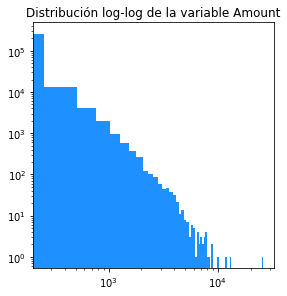

In [39]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
df["Amount"].hist(bins=100,ax=ax,facecolor='dodgerblue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(False)
fig.tight_layout() 
plt.title('Distribución log-log de la variable Amount')
plt.show()

In [35]:
# TODO: Nota para juanda - poner lo de pareto

Vemos ahora la correlación entre nuestras variables:

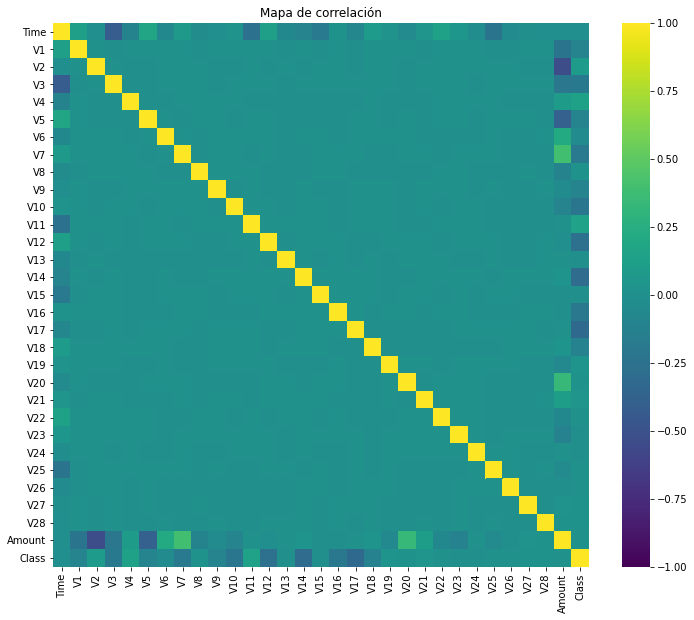

In [45]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr,vmin=-1.0,vmax=1.0,cmap="viridis")
plt.title('Mapa de correlación')
plt.show()

Como es de esperarse, por construcción, la correlación es cercana a cero entre los features del PCA, entonces lo realmente interesante sería observar las otras columnas. Se observa una anticorrelación interesante entre "Amount" y el V2 y un poco el V5 también. También hay una ligera anticorrelación entre "Time" y V3.

Ahora separamos nuestro conjuntos entre fraude y no-fraude y y re-escalamos usando la desviación estándar las variables que no han sido re-escaladas mediante el PCA, es decir las corresponientes a "Time" y "Amount". Luego construimos nuestro primer autoencoder. Procedemos a distribuir los datos de la clase normal entre entrenamiento y validación, y la clase de fraude entre una clase de validación y prueba. 

Usaremos los mismo Callbacks que se aplicaron en el primer problema, a saber "Early Stopping" y "Tensorboard".

### Particiones y preprocesamiento
Lo primero que hacemos es separar el target de las features, como vemos a continuación:

In [52]:
x = df.drop(["Class"], axis=1)
y = df["Class"].values

Ahora, separamos los datos entre normal y fraude:

In [53]:
x_normal, x_fraude = x[y == 0], x[y == 1]

Lo siguiente que hacemos es partir el conjunto de datos entre entrenamiento y validación. Como vamos a construir un autoencoder para la reconstrucción de anomalías, lo que debemos hacer es entrenar únicamente con los datos normales. Note que también tomamos un conjunto para realizar la validación de nuestro modelo (i.e. de la reconstrucción de transacciones normales).

No obstante, también partimos el conjunto de fraudes en dos. <code>X_fraude_train</code> lo utilizamos para ver (aún en entrenamiento) si efectivamente se detectan como anomalías las transacciones fraudulentas.

In [66]:
X_train, X_val, y_train, y_val = train_test_split(x_normal, np.ones(len(x_normal)), test_size=0.2, random_state=28)
X_fraude_train, X_fraude_test, y_fraude_train, y_fraude_test = train_test_split(x_fraude, np.ones(len(x_fraude)), test_size=0.2, random_state=28)

Ahora, seguimos con el preprocesamiento. Lo primero que hacemos es estandarizar (usando un StandardScaler()) las dos variables que no fueron escaladas durante el PCA. 